In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gpd

from scipy.spatial.distance import cdist

from shapely.geometry import Point, Polygon, MultiPolygon
import geopy.distance as gd
import matplotlib as mpl 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from barangay_preprocessor import barangays_preprocess

SCHOOL_PER_KM = r"Schools per km$^2$"

R_c = 5e3 #km
figsize = (12,12)

KERNEL_EXTENT = 100e3 #km
bbox_PH = {"lat_min":4.5, "lat_max": 21.1, "lon_min": 116, "lon_max":127.5}
bbox_NCR = {"lat_min":14.3183, "lat_max": 14.8154, "lon_min": 120.6464, "lon_max": 121.3948}

latlon = {"init": "epsg:4326"}
mercator = {"init": "epsg:32651"}

def calc_bins(values, bins=50):
     return np.logspace(np.log10(values.min()), np.log10(values.max()), bins)

def ecdf(degree):
    ecdf = ECDF(degree)
    return ecdf.x, ecdf.y

def pandas2geopandas(df, crs = latlon):
    geometry = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
    return gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

region_list = ["Region I", "Region II", "Region III", "Region IV-A", "Region IV-B", "Region V", "Region VI", "Region VII", "Region VIII", "Region IX", "Region X", "Region XI", "Region XII", "CARAGA", "ARMM", "CAR", "NCR"]
region_order = ["Region I", "Region II", "Region III", "Region IV-A", "Region IV-B", "Region V", "Region VI", "Region VII", "Region VIII", "Region IX", "Region X", "Region XI", "Region XII", "Region XIII", "ARMM", "CAR", "NCR"]

In [2]:
def kernel_powerlaw(xi, yi, alpha=1, R_c=1):
    x = np.arange(-KERNEL_EXTENT, +KERNEL_EXTENT+land_reso, land_reso)
    X, Y = np.meshgrid(x, x)
    R = np.sqrt(X**2 + Y**2)
    kernel = np.clip(((R/R_c)+1e-10)**-alpha, a_min=0, a_max=1)
    return kernel

def kernel_exponential(xi, yi, R_c=1):
    x = np.arange(-KERNEL_EXTENT, +KERNEL_EXTENT+land_reso, land_reso)
    X, Y = np.meshgrid(x, x)
    R = np.sqrt(X**2 + Y**2)
    kernel = np.exp(-(R/(R_c)))
    return kernel

def kernel_LoG(xi, yi, R_c=1):
    x = np.arange(-KERNEL_EXTENT, +KERNEL_EXTENT+land_reso, land_reso)
    X, Y = np.meshgrid(x, x)
    R = np.sqrt(X**2 + Y**2)
    kernel = (np.pi*R_c**2)**-1*(1-0.5*(R/R_c)**2)*np.exp(-0.5*(R/R_c)**2)
    return kernel

In [3]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [4]:
def get_school_barangay_slots(df, RegName, shape, column = "Grade 7 Total 2016"):
    df_subset = df[df.Region == RegName]
    return df_subset[df_subset.geometry.apply(lambda geom: geom.within(shape))].loc[:,column].sum()

# Preprocessing of the DepEd dataset
We obtained the DepEd dataset in excel format. Preprocessing fixes the GEOCODES, and updates some provinces that may have change over 2002-2015.

In [5]:
####Load files here

# barangays_PSGC_merge = barangays_preprocess().to_crs(mercator)
df_el_pop_updated = gpd.read_file("df_el_pop_updated.geojson").to_crs(mercator)

In [6]:
barangays_PSGC_merge["PSGC_6Digit"] = barangays_PSGC_merge.RegionCode_PSGC + barangays_PSGC_merge.ProvinceCode + barangays_PSGC_merge.MunicipalityCode
barangays_PSGC_merge["Province_Brgy"] = barangays_PSGC_merge.ProvinceName.str.upper()

### Standardize province names

In [8]:
mapping_df = {}
prov_list_school = list(set(df_el_pop_updated.Province.unique()) - set(barangays_PSGC_merge.ProvinceName.str.upper().unique()))
prov_list_school = ["CITY OF COTABATO", "ZAMBOANGA SIBUGAY", "MANILA, NCR,  FIRST DISTRICT ", 'NCR   SECOND DISTRICT', 'NCR   THIRD DISTRICT', "DINAGAT ISLANDS", 'NCR   FOURTH DISTRICT', 'WESTERN SAMAR' ]
prov_list_brgy   = ['COTABATO CITY', 'ZAMBOANGA DEL SUR', 'FIRST DISTRICT, CITY OF MANILA', 'SECOND DISTRICT', 'THIRD DISTRICT', 'SURIGAO DEL NORTE', 'FOURTH DISTRICT', 'SAMAR (WESTERN SAMAR)']

for i in range(len(prov_list_school)):
    mapping_df[prov_list_school[i]] = prov_list_brgy[i]

df_el_pop_updated["Province_Brgy"] = df_el_pop_updated.Province
df_el_pop_updated["Province_Brgy"] = df_el_pop_updated.Province_Brgy.replace(mapping_df)

In [9]:
barangays_shape = barangays_PSGC_merge.loc[:,["RegionName","geometry"]]
barangays_shape.geometry = barangays_shape.geometry.buffer(5)

In [10]:
barangays_PSGC_merge["el_school_barangay_slots"] = barangays_shape.apply(lambda x: get_school_barangay_slots(df_el_pop_updated, x.RegionName, x.geometry, column = "Grade 6 Total 2015"), axis = 1)

In [11]:
bbox = bbox_PH

bboxdf = gpd.GeoDataFrame(gpd.GeoSeries(Polygon([[[bbox["lon" + x], bbox["lat" + y]] 
                                         for x in ["_min", "_max"] 
                                         for y in ["_min","_max"]][i] for i in [0,1,3,2]])),
                  columns=['geometry'])

bboxdf.crs = {'init': 'epsg:4326'}

minx, miny, maxx, maxy = bboxdf.bounds.iloc[0]

In [12]:
bbox_NCR = {"lat_min":14.3183, "lat_max": 14.7975, "lon_min": 120.9286, "lon_max": 121.1394}
bboxdf_NCR = gpd.GeoDataFrame(gpd.GeoSeries(Polygon([[[bbox_NCR["lon" + x], bbox_NCR["lat" + y]] 
                                         for x in ["_min", "_max"] 
                                         for y in ["_min","_max"]][i] for i in [0,1,3,2]])),
                  columns=['geometry'])
bboxdf_NCR.crs = {'init': 'epsg:4326'}

bboxdf_NCR = bboxdf_NCR.to_crs(mercator)
NCR_minx, NCR_miny, NCR_maxx, NCR_maxy = bboxdf_NCR.bounds.iloc[0]

In [13]:
def aggregate_by(barangays, agg_level='RegionCode', eps=1):
    agg = barangays.loc[:,[agg_level,"geometry"]].copy()
    agg.loc[:,"geometry"] = agg.loc[:,"geometry"].buffer(0)
    
    agg = agg.dissolve(by=agg_level)
    agg.loc[:,"geometry"] = agg.loc[:,"geometry"].buffer(eps).buffer(-eps)
    return agg

In [14]:
#Shapes used by plotter
country = aggregate_by(barangays_PSGC_merge, agg_level='Country', eps = 5)
regions = aggregate_by(barangays_PSGC_merge, agg_level='RegionName', eps = 5)

In [15]:
land_reso = 0.5e3 # m

#transform bbox to epsg:32651
bboxdf = bboxdf.to_crs(mercator)
minx, miny, maxx, maxy = bboxdf.bounds.iloc[0]

x_edges = np.arange(minx, maxx, land_reso)
y_edges = np.arange(miny, maxy, land_reso)

# get the center of the histogram bins
X_centered, Y_centered = np.meshgrid(x_edges[:-1]+np.diff(x_edges)[0], y_edges[:-1]+np.diff(y_edges)[0])
X, Y = np.meshgrid(x_edges, y_edges)


In [16]:
def students_in_barangay_weighted(df, column, alpha=1, R_c=1):    
    kernel = np.clip(((cdist(list(zip(df.geometry.x, df.geometry.y)),
      list(zip(barangays_PSGC_merge.geometry.centroid.x, barangays_PSGC_merge.geometry.centroid.y)))/R_c)+1e-10)**-alpha, a_min=0, a_max=1)*(barangays_PSGC_merge.POP2K/barangays_PSGC_merge.POP2K.sum()).values
    
    print("Done calculating potential matrix.")
    return ( ((kernel.T * np.array(df.loc[:, column])) / np.sum(kernel, axis = 1)).T.sum(axis = 0))

In [17]:
def students_in_barangay_weighted_bounded(df, column = "Grade 6 Total 2015", brgy_df = barangays_PSGC_merge, alpha=1, R_c=1):        
    kernel = np.clip(((cdist(list(zip(df.geometry.x, df.geometry.y)),
      list(zip(brgy_df.geometry.centroid.x, brgy_df.geometry.centroid.y)))/R_c)+1e-10)**-alpha, a_min=0, a_max=1)*(brgy_df.POP2K/brgy_df.POP2K.sum()).values
    
    print("Done calculating potential matrix.")
    return ( ((kernel.T * np.array(df.loc[:, column])) / np.sum(kernel, axis = 1)).T.sum(axis = 0))

## Population scaling factor
Since our shapefiles are from the 2002 census, we had multiply a factor to account for population growth, before taking the fraction of the population that is aged X - Y years old.

In [18]:
pop_scaling_factor = (100979303/76413657)*0.02

### Basemap creation using available barangay shapefiles

In [19]:
def plot_map(barangays, agg, country=None):
    fig, ax = plt.subplots(1, figsize = (7,10), subplot_kw = dict(aspect = 'equal'))
    if country is not None:
        country.plot(ax=ax, color='none', linewidth=1, edgecolor="#cccccc", alpha=1, legend=True, zorder=10)
    agg.plot(ax=ax, color='none', linewidth=0.5, linestyle="-", edgecolor="black", alpha=1, legend=True, zorder=10)#
    ax.set_xlim(xmin=minx, xmax=maxx)
    ax.set_ylim(ymin=miny, ymax=maxy)

    return fig, ax

### Calculating modeled number of students in barangays

In [20]:
size = 7000
count = 0
el_students_in_brgy_weighted_total = np.zeros(len(barangays_PSGC_merge))
df_el_pop_updated = df_el_pop_updated.dropna(subset = ["Grade 6 Total 2015"])


for pos in np.arange(0, len(df_el_pop_updated), size):
     el_students_in_brgy_weighted_array = students_in_barangay_weighted(df_el_pop_updated.loc[pos:pos+size], "Grade 6 Total 2015", alpha = 2, R_c = R_c )

    
     print(el_students_in_brgy_weighted_array)
     el_students_in_brgy_weighted_total += el_students_in_brgy_weighted_array
    
     count+=1
     print("Done with %sth set" % count)



Done calculating potential matrix.
[ 6.28623571  3.34799413  3.04587806 ... 19.78196778 12.6963638
 14.02026244]
Done with 1th set
Done calculating potential matrix.
[12.40254564  6.04874853  7.10310578 ...  0.20276747  0.15023028
  0.21672759]
Done with 2th set
Done calculating potential matrix.
[0.50232736 0.25668975 0.2739015  ... 0.07444291 0.05522486 0.08008684]
Done with 3th set
Done calculating potential matrix.
[0.30163362 0.15428079 0.16363966 ... 0.06349607 0.04713971 0.06849411]
Done with 4th set
Done calculating potential matrix.
[0.2332857  0.11976651 0.12541689 ... 0.57462019 0.44392485 0.57408933]
Done with 5th set
Done calculating potential matrix.
[34.17650182 16.26193315 15.47101364 ...  0.21561195  0.16040798
  0.22117444]
Done with 6th set


In [21]:
barangays_PSGC_merge["el_students_in_barangay_weighted"] = el_students_in_brgy_weighted_total

### Calculation of modeled number of students while limiting cross-enrollment

#### Regional boundaries

In [22]:
for region in region_list:
    brgy_subset = barangays_PSGC_merge.RegionName == region
    df_subset = df_el_pop_updated.Region == region
    
    el_students_in_barangay_bound = students_in_barangay_weighted_bounded(df = df_el_pop_updated[df_subset], brgy_df = barangays_PSGC_merge[brgy_subset], alpha = 2, R_c = R_c)
    print("For %s:" % region)
    print(el_students_in_barangay_bound)
    
    barangays_PSGC_merge.loc[barangays_PSGC_merge[brgy_subset].index,"el_students_in_brgy_weighted_regional"] = el_students_in_barangay_bound



Done calculating potential matrix.
For Region I:
[62.63074788 44.43954231 31.83327918 ... 24.56829089 15.82445722
 17.08795922]
Done calculating potential matrix.
For Region II:
[12.99354606 22.94100282 44.3586659  ... 38.45896466 31.6651752
  6.7135534 ]
Done calculating potential matrix.
For Region III:
[21.37477113 50.3452485  13.03848975 ... 93.93198005 52.13618291
 48.61166053]
Done calculating potential matrix.
For Region IV-A:
[  59.85992883 1250.22801301  335.63168937 ...   58.85007979  134.1842863
   88.36871193]
Done calculating potential matrix.
For Region IV-B:
[35.28635245 26.85267854 55.41183314 ... 13.66708516 15.32535857
 10.64577038]
Done calculating potential matrix.
For Region V:
[28.45496409 44.81204939  7.90967867 ... 10.02055023 19.17405452
 16.18555104]
Done calculating potential matrix.
For Region VI:
[ 30.5815118   19.37831175  36.41485029 ... 266.7600094  192.21379695
  61.95800011]
Done calculating potential matrix.
For Region VII:
[ 2.75182068 14.04580713 13

#### Provincial boundaries

In [23]:
for province in barangays_PSGC_merge.Province_Brgy.unique():
    brgy_subset = barangays_PSGC_merge.Province_Brgy == province
    df_subset = df_el_pop_updated.Province_Brgy == province
    
    el_students_in_barangay_bound = students_in_barangay_weighted_bounded(df = df_el_pop_updated[df_subset], brgy_df = barangays_PSGC_merge[brgy_subset], alpha = 2, R_c = R_c)
    print("For %s:" % province)
    
    barangays_PSGC_merge.loc[barangays_PSGC_merge[brgy_subset].index,"el_students_in_brgy_weighted_provincial"] = el_students_in_barangay_bound

Done calculating potential matrix.
For FIRST DISTRICT, CITY OF MANILA:
Done calculating potential matrix.
For FOURTH DISTRICT:
Done calculating potential matrix.
For THIRD DISTRICT:
Done calculating potential matrix.
For SECOND DISTRICT:
Done calculating potential matrix.
For APAYAO:
Done calculating potential matrix.
For MOUNTAIN PROVINCE:
Done calculating potential matrix.
For KALINGA:
Done calculating potential matrix.
For IFUGAO:
Done calculating potential matrix.
For BENGUET:
Done calculating potential matrix.
For ABRA:
Done calculating potential matrix.
For TAWI-TAWI:
Done calculating potential matrix.
For SULU:
Done calculating potential matrix.
For MAGUINDANAO:
Done calculating potential matrix.
For LANAO DEL SUR:
Done calculating potential matrix.
For SURIGAO DEL SUR:
Done calculating potential matrix.
For SURIGAO DEL NORTE:
Done calculating potential matrix.
For AGUSAN DEL SUR:
Done calculating potential matrix.
For AGUSAN DEL NORTE:
Done calculating potential matrix.
For COT

# Inverse enrollment pressure

/usr/local/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.03,0.5,'Count')

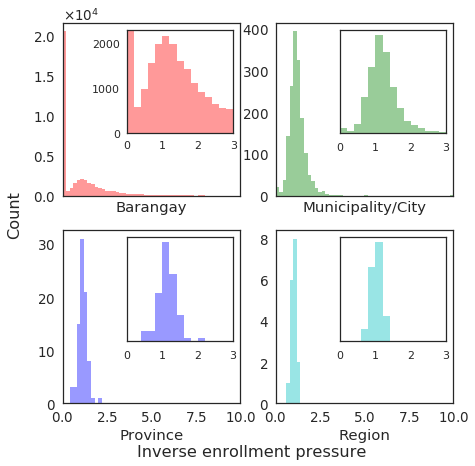

In [24]:
sns.set(font_scale = 1.35, style = "white")
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

xmax = 10
inset_xmax = 3
step = 0.2

bin_edge = np.arange(0,xmax+step,step)
bin_inset =np.arange(0,inset_xmax+step,step)

#xlabel = "Ratio of elementary school slots to elementary students"
xlabel = "Inverse enrollment pressure"
ylabel = "Count"

barangays_PSGC_merge["barangay_slots_to_el_students_in_barangay_weighted_ratio"] = barangays_PSGC_merge.el_school_barangay_slots/(barangays_PSGC_merge.el_students_in_barangay_weighted + 1e-10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=False, figsize =(7,7))

MunicipalityGroup = barangays_PSGC_merge.groupby("PSGC_6Digit").sum()
ProvinceGroup = barangays_PSGC_merge.groupby("ProvinceCode").sum()
RegionGroup = barangays_PSGC_merge.groupby("RegionName").sum()


for i in range(len(ax.flatten())):
    ax.flatten()[i].ticklabel_format(style='sci',scilimits=(-3,3), axis = "both")
    ax.flatten()[i].xaxis.major.formatter._useMathText = True
    ax.flatten()[i].yaxis.major.formatter._useMathText = True
    ax.flatten()[i].set_xlim([0,xmax])
    
# ax.flatten()[3].set_ylim([0,12])

axin = inset_axes(ax.flatten()[0],
                    width="60%", 
                    height="60%", 
                    loc = 1)
#axin.ticklabel_format(style='sci',scilimits=(-3,3), axis = "both", useMathText = True)
axin.tick_params(labelsize=11)
axin.set_xlim(0, inset_xmax)
axin.set_ylim(0, 2300)
axin.get_yaxis().set_offset_position('left')
#axin.get_yaxis().set_visible(False)

axin1 = inset_axes(ax.flatten()[1],
                    width="60%", 
                    height="60%", 
                    loc = 1)
axin1.ticklabel_format(style='sci',scilimits=(-3,3), axis = "both", useMathText = True)
axin1.tick_params(labelsize=11)
axin1.set_xlim(0, inset_xmax)
axin1.get_yaxis().set_visible(False)

axin2 = inset_axes(ax.flatten()[2],
                    width="60%", 
                    height="60%", 
                    loc = 1)
axin2.ticklabel_format(style='sci',scilimits=(-3,3), axis = "both", useMathText = True)
axin2.tick_params(labelsize=11)
axin2.set_xlim(0, inset_xmax)
axin2.get_yaxis().set_visible(False)

axin3 = inset_axes(ax.flatten()[3],
                    width="60%", 
                    height="60%", 
                    loc = 1)
axin3.ticklabel_format(style='sci',scilimits=(-3,3), axis = "both", useMathText = True)
axin3.tick_params(labelsize=11)
axin3.set_xlim(0, inset_xmax)
axin3.get_yaxis().set_visible(False)

#Subplot plots
sns.distplot(barangays_PSGC_merge.barangay_slots_to_el_students_in_barangay_weighted_ratio[barangays_PSGC_merge.barangay_slots_to_el_students_in_barangay_weighted_ratio < 100000], kde = False, ax = ax.flatten()[0], bins = bin_edge, axlabel = "Barangay", color = "r")
sns.distplot(MunicipalityGroup.el_school_barangay_slots/MunicipalityGroup.el_students_in_barangay_weighted, ax = ax.flatten()[1], kde = False, bins = bin_edge, axlabel = "Municipality/City", color = "g")
sns.distplot(ProvinceGroup.el_school_barangay_slots/ProvinceGroup.el_students_in_barangay_weighted, ax = ax.flatten()[2], kde = False, bins = bin_edge, axlabel = "Province", color = "b")
sns.distplot(RegionGroup.el_school_barangay_slots/RegionGroup.el_students_in_barangay_weighted, ax = ax.flatten()[3], kde = False, bins = bin_edge, axlabel = "Region", color = "c")

#Inset plots
sns.distplot(barangays_PSGC_merge.barangay_slots_to_el_students_in_barangay_weighted_ratio[barangays_PSGC_merge.barangay_slots_to_el_students_in_barangay_weighted_ratio < 100000], kde = False, ax = axin, axlabel = "", color = "r", bins = bin_inset)
sns.distplot(MunicipalityGroup.el_school_barangay_slots/MunicipalityGroup.el_students_in_barangay_weighted, ax = axin1, kde = False, axlabel = "", color = "g", bins = bin_inset)
sns.distplot(ProvinceGroup.el_school_barangay_slots/ProvinceGroup.el_students_in_barangay_weighted, ax = axin2, kde = False, axlabel = "", color = "b", bins = bin_inset)
sns.distplot(RegionGroup.el_school_barangay_slots/RegionGroup.el_students_in_barangay_weighted, ax = axin3, kde = False, axlabel = "", color = "c", bins = bin_inset)


fig.text(0.5, 0.03, xlabel, ha='center', va='center')
fig.text(0.03, 0.5, ylabel, ha='center', va='center', rotation='vertical')


#plt.savefig("../files/images/EIDR_ElementarySlots_to_Students_Weighted.pdf", bbox_inches = "tight")

# Distributions of Effectivity
## No imposed boundaries

/usr/local/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.0005,0.5,'Count')

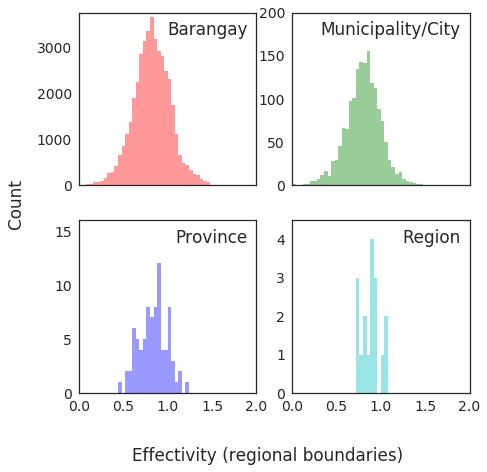

In [25]:
sns.set(font_scale = 1.4, style = "white")

num_bin = 50
bin_edge = np.linspace(0,2,num_bin + 1)

xlabel = "Effectivity (regional boundaries)"
ylabel = "Count"
key = "el_students_in_barangay_weighted"
fig, ax = plt.subplots(2, 2, sharex=True, sharey=False, figsize =(7,7))
axes = ax.flatten()
plt.setp(ax, xlim=[0, 2])

barangays_PSGC_merge["effectivity_weighted"] = barangays_PSGC_merge[key]/np.ceil(barangays_PSGC_merge.POP2K*pop_scaling_factor)
MunicipalityGroup = barangays_PSGC_merge.groupby("PSGC_6Digit").sum()
ProvinceGroup = barangays_PSGC_merge.groupby("Province_Brgy").sum()
RegionGroup = barangays_PSGC_merge.groupby("RegionName").sum()

sns.distplot(
    barangays_PSGC_merge.effectivity_weighted[barangays_PSGC_merge.effectivity_weighted < 100000], kde=False, ax=axes[0], bins=bin_edge, axlabel=False, color="r")
axes[0].text(0.95, 0.95, 'Barangay', horizontalalignment='right',
             verticalalignment='top', transform=axes[0].transAxes)
sns.distplot(MunicipalityGroup[key]/np.ceil(MunicipalityGroup.POP2K *
                                            pop_scaling_factor), ax=axes[1], kde=False, bins=bin_edge, color="g")
axes[1].text(0.95, 0.95, 'Municipality/City', horizontalalignment='right',
             verticalalignment='top', transform=axes[1].transAxes)
sns.distplot(ProvinceGroup[key]/np.ceil(ProvinceGroup.POP2K *
                                        pop_scaling_factor), ax=axes[2], kde=False, bins=bin_edge, color="b")
axes[2].text(0.95, 0.95, 'Province', horizontalalignment='right',
             verticalalignment='top', transform=axes[2].transAxes)
sns.distplot(RegionGroup[key]/np.ceil(RegionGroup.POP2K *
                                      pop_scaling_factor), ax=axes[3], kde=False, bins=bin_edge, color="c")
axes[3].text(0.95, 0.95, 'Region', horizontalalignment='right',
             verticalalignment='top', transform=axes[3].transAxes)

axes[0].set_ylim([0,3750])
axes[1].set_ylim([0,200])
axes[2].set_ylim([0,16])
axes[3].set_ylim([0,4.5])

fig.text(0.5, 0.0005, xlabel, ha='center', va='center')
fig.text(0.0005, 0.5, ylabel, ha='center', va='center', rotation='vertical')

#plt.savefig("../files/images/EIDR_EffectivityElemSchool_Weighted.pdf", bbox_inches = "tight")

## Regional boundaries imposed

/usr/local/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.0005,0.5,'Count')

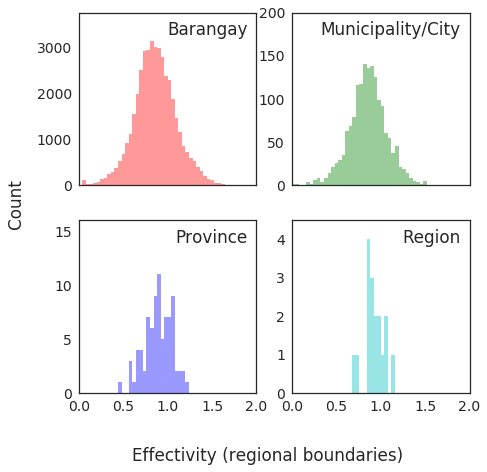

In [26]:
sns.set(font_scale = 1.4, style = "white")

num_bin = 50
bin_edge = np.linspace(0,2,num_bin + 1)

xlabel = "Effectivity (regional boundaries)"
ylabel = "Count"
key = "el_students_in_brgy_weighted_regional"
fig, ax = plt.subplots(2, 2, sharex=True, sharey=False, figsize =(7,7))
axes = ax.flatten()
plt.setp(ax, xlim=[0, 2])

barangays_PSGC_merge["effectivity_weighted_regional"] = barangays_PSGC_merge[key]/np.ceil(barangays_PSGC_merge.POP2K*pop_scaling_factor)
MunicipalityGroup = barangays_PSGC_merge.groupby("PSGC_6Digit").sum()
ProvinceGroup = barangays_PSGC_merge.groupby("Province_Brgy").sum()
RegionGroup = barangays_PSGC_merge.groupby("RegionName").sum()

sns.distplot(
    barangays_PSGC_merge.effectivity_weighted_regional[barangays_PSGC_merge.effectivity_weighted_regional < 100000], kde=False, ax=axes[0], bins=bin_edge, axlabel=False, color="r")
axes[0].text(0.95, 0.95, 'Barangay', horizontalalignment='right',
             verticalalignment='top', transform=axes[0].transAxes)
sns.distplot(MunicipalityGroup[key]/np.ceil(MunicipalityGroup.POP2K *
                                            pop_scaling_factor), ax=axes[1], kde=False, bins=bin_edge, color="g")
axes[1].text(0.95, 0.95, 'Municipality/City', horizontalalignment='right',
             verticalalignment='top', transform=axes[1].transAxes)
sns.distplot(ProvinceGroup[key]/np.ceil(ProvinceGroup.POP2K *
                                        pop_scaling_factor), ax=axes[2], kde=False, bins=bin_edge, color="b")
axes[2].text(0.95, 0.95, 'Province', horizontalalignment='right',
             verticalalignment='top', transform=axes[2].transAxes)
sns.distplot(RegionGroup[key]/np.ceil(RegionGroup.POP2K *
                                      pop_scaling_factor), ax=axes[3], kde=False, bins=bin_edge, color="c")
axes[3].text(0.95, 0.95, 'Region', horizontalalignment='right',
             verticalalignment='top', transform=axes[3].transAxes)

axes[0].set_ylim([0,3750])
axes[1].set_ylim([0,200])
axes[2].set_ylim([0,16])
axes[3].set_ylim([0,4.5])

fig.text(0.5, 0.0005, xlabel, ha='center', va='center')
fig.text(0.0005, 0.5, ylabel, ha='center', va='center', rotation='vertical')

#plt.savefig("../files/images/EIDR_EffectivityElemSchool_RegionalBounds_Weighted.pdf", bbox_inches = "tight")

## Provincial boundaries imposed

/usr/local/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.0005,0.5,'Count')

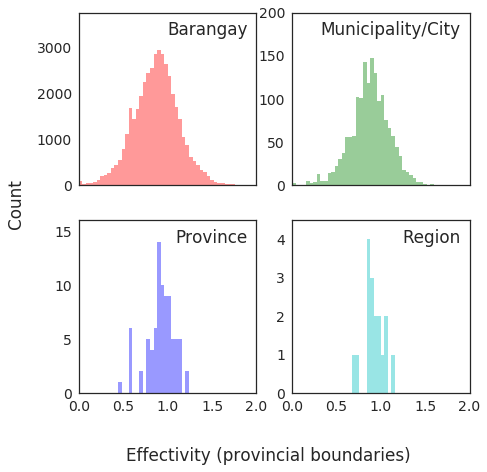

In [27]:
sns.set(font_scale=1.4, style="white")

num_bin = 50
bin_edge = np.linspace(0, 2, num_bin + 1)

xlabel = "Effectivity (provincial boundaries)"
ylabel = "Count"
key = "el_students_in_brgy_weighted_provincial"

fig, ax = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(7, 7))
axes = ax.flatten()
plt.setp(ax, xlim=[0, 2])

barangays_PSGC_merge["effectivity_weighted_provincial"] = barangays_PSGC_merge[key] / \
    np.ceil(barangays_PSGC_merge.POP2K*pop_scaling_factor)
MunicipalityGroup = barangays_PSGC_merge.groupby("PSGC_6Digit").sum()
ProvinceGroup = barangays_PSGC_merge.groupby("Province_Brgy").sum()
RegionGroup = barangays_PSGC_merge.groupby("RegionName").sum()

sns.distplot(
    barangays_PSGC_merge.effectivity_weighted_provincial[barangays_PSGC_merge.effectivity_weighted_provincial < 100000], kde=False, ax=axes[0], bins=bin_edge, axlabel=False, color="r")
axes[0].text(0.95, 0.95, 'Barangay', horizontalalignment='right',
             verticalalignment='top', transform=axes[0].transAxes)
sns.distplot(MunicipalityGroup[key]/np.ceil(MunicipalityGroup.POP2K *
                                            pop_scaling_factor), ax=axes[1], kde=False, bins=bin_edge, color="g")
axes[1].text(0.95, 0.95, 'Municipality/City', horizontalalignment='right',
             verticalalignment='top', transform=axes[1].transAxes)
sns.distplot(ProvinceGroup[key]/np.ceil(ProvinceGroup.POP2K *
                                        pop_scaling_factor), ax=axes[2], kde=False, bins=bin_edge, color="b")
axes[2].text(0.95, 0.95, 'Province', horizontalalignment='right',
             verticalalignment='top', transform=axes[2].transAxes)
sns.distplot(RegionGroup[key]/np.ceil(RegionGroup.POP2K *
                                      pop_scaling_factor), ax=axes[3], kde=False, bins=bin_edge, color="c")
axes[3].text(0.95, 0.95, 'Region', horizontalalignment='right',
             verticalalignment='top', transform=axes[3].transAxes)

axes[0].set_ylim([0, 3750])
axes[1].set_ylim([0, 200])
axes[2].set_ylim([0, 16])
axes[3].set_ylim([0, 4.5])

fig.text(0.5, 0.0005, xlabel, ha='center', va='center')
fig.text(0.0005, 0.5, ylabel, ha='center', va='center', rotation='vertical')

#plt.savefig("../files/images/EIDR_EffectivityElemSchool_ProvincialBounds_Weighted.pdf", bbox_inches = "tight")


### IQR - No boundaries

In [28]:
barangays_PSGC_merge.effectivity_weighted[barangays_PSGC_merge.effectivity_weighted < 100000].quantile([0.25, 0.5, 0.75])

0.25    0.693018
0.50    0.822178
0.75    0.958745
Name: effectivity_weighted, dtype: float64

In [29]:
(MunicipalityGroup.el_students_in_barangay_weighted/np.ceil(MunicipalityGroup.POP2K*pop_scaling_factor)).quantile([0.25, 0.5, 0.75])

0.25    0.683373
0.50    0.807894
0.75    0.929098
dtype: float64

In [30]:
(ProvinceGroup.el_students_in_barangay_weighted/np.ceil(ProvinceGroup.POP2K*pop_scaling_factor)).quantile([0.25, 0.5, 0.75])

0.25    0.727081
0.50    0.847309
0.75    0.934429
dtype: float64

In [31]:
(RegionGroup.el_students_in_barangay_weighted/np.ceil(RegionGroup.POP2K*pop_scaling_factor)).quantile([0.25, 0.5, 0.75])

0.25    0.834384
0.50    0.903853
0.75    0.944401
dtype: float64

### IQR - Boundaries (regional)

In [32]:
barangays_PSGC_merge.effectivity_weighted_regional[barangays_PSGC_merge.effectivity_weighted_regional < 100000].quantile([0.25, 0.5, 0.75])

0.25    0.713445
0.50    0.854662
0.75    1.007027
Name: effectivity_weighted_regional, dtype: float64

In [33]:
(MunicipalityGroup.el_students_in_brgy_weighted_regional/np.ceil(MunicipalityGroup.POP2K*pop_scaling_factor)).quantile([0.25, 0.5, 0.75])

0.25    0.729820
0.50    0.859353
0.75    0.988542
dtype: float64

In [34]:
(ProvinceGroup.el_students_in_brgy_weighted_regional/np.ceil(ProvinceGroup.POP2K*pop_scaling_factor)).quantile([0.25, 0.5, 0.75])

0.25    0.796510
0.50    0.891002
0.75    1.006511
dtype: float64

In [35]:
(RegionGroup.el_students_in_brgy_weighted_regional/np.ceil(RegionGroup.POP2K*pop_scaling_factor)).quantile([0.25, 0.5, 0.75])

0.25    0.863911
0.50    0.909991
0.75    0.998499
dtype: float64

### IQR - Boundaries (provincial)

In [36]:
barangays_PSGC_merge.effectivity_weighted_provincial[barangays_PSGC_merge.effectivity_weighted_provincial < 100000].quantile([0.25, 0.5, 0.75])

0.25    0.707558
0.50    0.877128
0.75    1.030478
Name: effectivity_weighted_provincial, dtype: float64

In [37]:
(MunicipalityGroup.el_students_in_brgy_weighted_provincial/np.ceil(MunicipalityGroup.POP2K*pop_scaling_factor)).quantile([0.25, 0.5, 0.75])

0.25    0.752177
0.50    0.886320
0.75    1.023179
dtype: float64

In [38]:
(ProvinceGroup.el_students_in_brgy_weighted_provincial/np.ceil(ProvinceGroup.POP2K*pop_scaling_factor)).quantile([0.25, 0.5, 0.75])

0.25    0.856713
0.50    0.936428
0.75    1.022447
dtype: float64

In [39]:
(RegionGroup.el_students_in_brgy_weighted_provincial/np.ceil(RegionGroup.POP2K*pop_scaling_factor)).quantile([0.25, 0.5, 0.75])

0.25    0.863911
0.50    0.909991
0.75    0.998499
dtype: float64

### Differences in Effectivity

In [40]:
DiffBrgyUnboundWeighted = pd.DataFrame(((ProvinceGroup.el_students_in_brgy_weighted_regional/np.ceil(ProvinceGroup.POP2K*pop_scaling_factor)) - (ProvinceGroup.el_students_in_barangay_weighted/np.ceil(ProvinceGroup.POP2K*pop_scaling_factor)))).rename(columns = {0:"difference_brgy_unbound_weighted"}).reset_index()

In [41]:
DiffProvRegWeighted = pd.DataFrame((ProvinceGroup.el_students_in_brgy_weighted_provincial/np.ceil(ProvinceGroup.POP2K*pop_scaling_factor)) - (ProvinceGroup.el_students_in_brgy_weighted_regional/np.ceil(ProvinceGroup.POP2K*pop_scaling_factor))).rename(columns = {0:"difference_prov_regional_weighted"}).reset_index()

In [42]:
DiffBrgyUnboundWeighted = pd.DataFrame(((ProvinceGroup.el_students_in_brgy_weighted_regional/np.ceil(ProvinceGroup.POP2K*pop_scaling_factor)) - (ProvinceGroup.el_students_in_barangay_weighted/np.ceil(ProvinceGroup.POP2K*pop_scaling_factor)))).rename(columns = {0:"difference_brgy_unbound_weighted"}).reset_index()

In [43]:
provinces = aggregate_by(barangays_PSGC_merge, agg_level='Province_Brgy', eps = 5)

provinces_merged = pd.merge(provinces.reset_index(), DiffProvRegWeighted, on = "Province_Brgy")
provinces_merged = pd.merge(provinces_merged, DiffBrgyUnboundWeighted, on = "Province_Brgy")


(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f19128b4080>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f19128b41d0>)

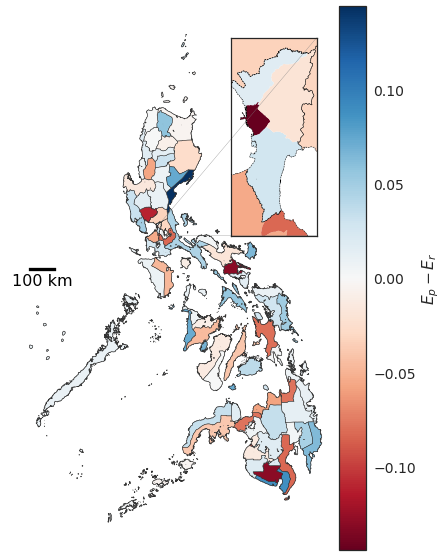

In [44]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=16)


variable = "difference_prov_regional_weighted"
cmap_name = "RdBu"

fig, ax = plot_map(barangays_PSGC_merge, agg = provinces, country=country)

vmin = provinces_merged[variable].min()
vmax = provinces_merged[variable].max()

vmax = np.array(np.abs(vmin), np.abs(vmax)).max()
vmin = -vmax

scale_length = 100
scalebar = AnchoredSizeBar(ax.transData,
scale_length*1e3, '%s km' % scale_length, 'center left', 
pad=0.2,
frameon=False,
size_vertical=10000, #scale this
fontproperties=fontprops,
)

ax.add_artist(scalebar)

provinces_merged.plot(column=variable, cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax), linewidth=0.5, ax=ax, edgecolor='0.2', zorder = 10)

ax.axis('off')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#ax.set_title("Difference between effectivity bounded at the provincial and regional level (provincial aggregation)")


sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax))
sm._A = []

cbar = fig.colorbar(sm, pad = -0.025)
cbar.ax.set_ylabel(r"$E_p - E_r$")


axin = inset_axes(ax,
                    width="40%", 
                    height="40%", 
                    loc = 1,axes_kwargs = {"aspect":'equal'})


plt.yticks(visible=False)
plt.xticks(visible=False)

regions.plot(ax=axin, color='none', linewidth=0.5, linestyle="--", edgecolor="black", alpha=1, legend=True, zorder=10)
provinces_merged.plot(column=variable, cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax), linewidth=0.5, ax=axin, edgecolor='None')

axin.set_xlim([NCR_minx, NCR_maxx])
axin.set_ylim([NCR_miny, NCR_maxy])


from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axin, loc1=1, loc2=4, fc="none", ec="0.5")

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f1912582c88>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f1912582b00>)

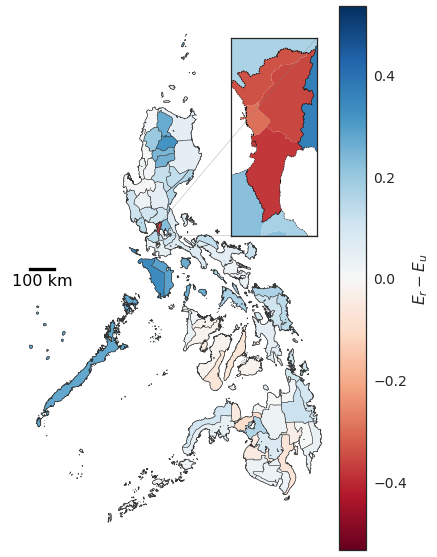

In [45]:
variable = "difference_brgy_unbound_weighted"
cmap_name = "RdBu"

fig, ax = plot_map(barangays_PSGC_merge, agg = regions, country=country)

vmin = provinces_merged[variable].min()
vmax = provinces_merged[variable].max()

vmax = np.array(np.abs(vmin), np.abs(vmax)).max()
vmin = -vmax

scale_length = 100
scalebar = AnchoredSizeBar(ax.transData,
scale_length*1e3, '%s km' % scale_length, 'center left', 
pad=0.2,
frameon=False,
size_vertical=10000, #scale this
fontproperties=fontprops,
)

ax.add_artist(scalebar)

norm = MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax)

provinces_merged.plot(column=variable, cmap=cmap_name, norm=norm, vmin = vmin, vmax = vmax, linewidth=0.5, ax=ax, edgecolor='0.2', zorder = 10)

ax.axis('off')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#ax.set_title("Difference between regional effectivity and unbounded effectivity (provincial aggregation)")

sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=norm)
sm._A = []

cbar = fig.colorbar(sm, pad = -0.025)
cbar.ax.set_ylabel(r"$E_r - E_u$")


axin = inset_axes(ax,
                    width="40%", 
                    height="40%", 
                    loc = 1,axes_kwargs = {"aspect":'equal'})

plt.yticks(visible=False)
plt.xticks(visible=False)

regions.plot(ax=axin, color='none', linewidth=0.5, linestyle="--", edgecolor="black", alpha=1, legend=True, zorder=10)
provinces_merged.plot(column=variable, cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax), linewidth=0.5, ax=axin, edgecolor='None')

axin.set_xlim([NCR_minx, NCR_maxx])
axin.set_ylim([NCR_miny, NCR_maxy])

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axin, loc1=1, loc2=4, fc="none", ec="0.5")

In [46]:
barangays_PSGC_merge_nonzeroPOP = barangays_PSGC_merge[barangays_PSGC_merge.effectivity_weighted < 100000000].copy()

In [47]:
barangays_PSGC_merge_nonzeroPOP["difference_prov_regional_weighted"] = barangays_PSGC_merge_nonzeroPOP.effectivity_weighted_provincial - barangays_PSGC_merge_nonzeroPOP.effectivity_weighted_regional

In [48]:
barangays_PSGC_merge_nonzeroPOP["difference_brgy_unbound_weighted"] = barangays_PSGC_merge_nonzeroPOP.effectivity_weighted_regional - barangays_PSGC_merge_nonzeroPOP.effectivity_weighted

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f19124fee80>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f1912317cf8>)

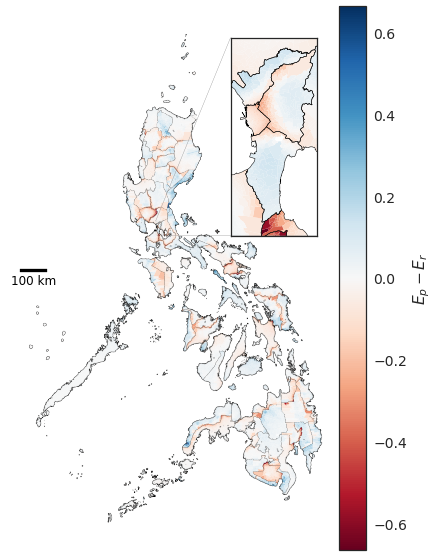

In [49]:
variable = "difference_prov_regional_weighted"
cmap_name = "RdBu"

fig, ax = plot_map(barangays_PSGC_merge, agg = provinces, country=country)

vmin = barangays_PSGC_merge_nonzeroPOP[variable].min()
vmax = barangays_PSGC_merge_nonzeroPOP[variable].max()

vmax = np.array(np.abs(vmin), np.abs(vmax)).max()
vmin = -vmax

fontprops = fm.FontProperties(size=12)
scale_length = 100
scalebar = AnchoredSizeBar(ax.transData,
scale_length*1e3, '%s km' % scale_length, 'center left', 
pad=0.2,
frameon=False,
size_vertical=10000, #scale this
fontproperties=fontprops,
)

ax.add_artist(scalebar)

barangays_PSGC_merge_nonzeroPOP.plot(column=variable, cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax), linewidth=0.5, ax=ax, edgecolor='None', zorder = 10)

ax.axis('off')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


ax.set_xlim([minx, maxx])
# ax.set_title("Difference between effectivity bounded at the provincial and regional level")

sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax))
sm._A = []

cbar = fig.colorbar(sm, pad = -0.025)
cbar.ax.set_ylabel(r"$E_p - E_r$")


axin = inset_axes(ax,
                    width="40%", 
                    height="40%", 
                    loc = 1,axes_kwargs = {"aspect":'equal'})

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.yticks(visible=False)
plt.xticks(visible=False)

provinces.plot(ax=axin, color='none', linewidth=0.5, linestyle="-", edgecolor="black", alpha=1, legend=True, zorder=10)
barangays_PSGC_merge_nonzeroPOP.plot(column=variable, cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax), linewidth=0.5, ax=axin, edgecolor='None')

axin.set_xlim([NCR_minx, NCR_maxx])
axin.set_ylim([NCR_miny, NCR_maxy])

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axin, loc1=2, loc2=4, fc="none", ec="0.5")

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f1901768908>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f19121bf240>)

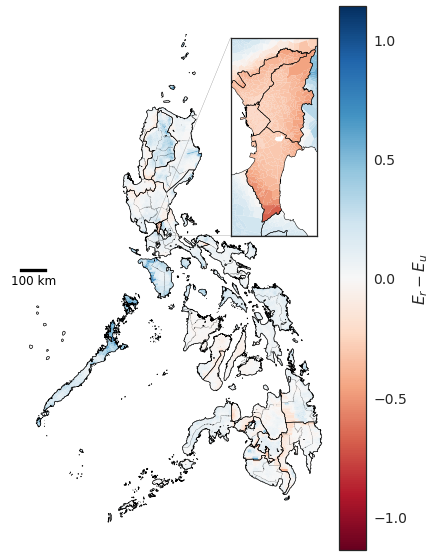

In [50]:
variable = "difference_brgy_unbound_weighted"
cmap_name = "RdBu"


vmin = barangays_PSGC_merge_nonzeroPOP[variable].min()
vmax = barangays_PSGC_merge_nonzeroPOP[variable].max()

fig, ax = plot_map(barangays_PSGC_merge, agg = provinces, country=country)

vmax = np.array(np.abs(vmin), np.abs(vmax)).max()
vmin = -vmax

fontprops = fm.FontProperties(size=12)

scale_length = 100
scalebar = AnchoredSizeBar(ax.transData,
scale_length*1e3, '%s km' % scale_length, 'center left', 
pad=0.2,
frameon=False,
size_vertical=10000, #scale this
fontproperties=fontprops,
)

ax.add_artist(scalebar)


barangays_PSGC_merge_nonzeroPOP.plot(column=variable, cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax), linewidth=0.5, ax=ax, edgecolor='None', zorder = 10)

ax.axis('off')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#ax.set_title("Difference between regional effectivity and unbounded effectivity")

sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax))
sm._A = []

cbar = fig.colorbar(sm, pad = -0.025)
cbar.ax.set_ylabel(r"$E_r - E_u$")

axin = inset_axes(ax,
                    width="40%", 
                    height="40%", 
                    loc = 1,axes_kwargs = {"aspect":'equal'})

plt.yticks(visible=False)
plt.xticks(visible=False)

provinces.plot(ax=axin, color='none', linewidth=0.5, linestyle="-", edgecolor="black", alpha=1, legend=True, zorder=10)
regions.plot(ax=ax, color='none', linewidth=0.5, linestyle="-", edgecolor="black", alpha=1, legend=True, zorder=10)

barangays_PSGC_merge_nonzeroPOP.plot(column=variable, cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax), linewidth=0.5, ax=axin, edgecolor='None')

axin.set_xlim([NCR_minx, NCR_maxx])
axin.set_ylim([NCR_miny, NCR_maxy])


fontprops = fm.FontProperties(size=10)


from mpl_toolkits.axes_grid1.inset_locator import mark_inset
mark_inset(ax, axin, loc1=2, loc2=4, fc="none", ec="0.5")

In [51]:
barangays_PSGC_merge["barangay_slots_to_el_students_in_barangay_weighted_ratio"] = barangays_PSGC_merge.el_school_barangay_slots/barangays_PSGC_merge.el_students_in_barangay_weighted

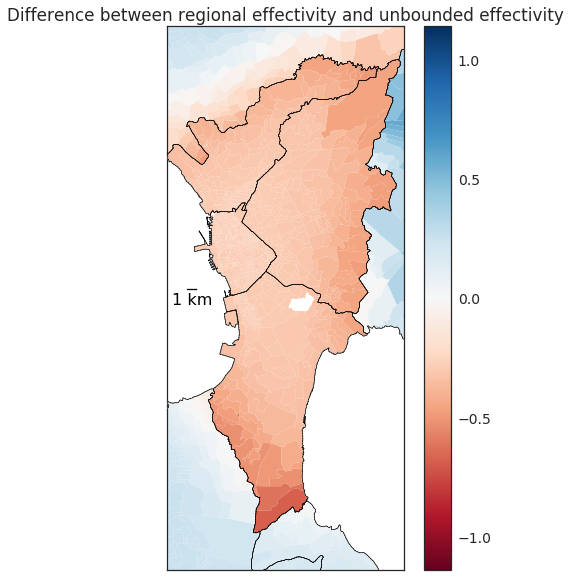

In [52]:
variable = "difference_brgy_unbound_weighted"
cmap_name = "RdBu"



vmin = barangays_PSGC_merge_nonzeroPOP[variable].min()
vmax = barangays_PSGC_merge_nonzeroPOP[variable].max()

fig, ax = plot_map(barangays_PSGC_merge, agg = provinces, country=country)

vmax = np.array(np.abs(vmin), np.abs(vmax)).max()
vmin = -vmax

fontprops = fm.FontProperties(size=16)

scale_length = 1
scalebar = AnchoredSizeBar(ax.transData,
scale_length*1e3, '%s km' % scale_length, 'center left', 
pad=0.2,
frameon=False,
size_vertical=100, #scale this
fontproperties=fontprops,
)

ax.add_artist(scalebar)


provinces.plot(ax=ax, color='none', linewidth=0.5, linestyle="--", edgecolor="black", alpha=1, legend=True, zorder=10)
barangays_PSGC_merge_nonzeroPOP.plot(column=variable, cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax), linewidth=0.5, ax=ax, edgecolor='None')

ax.set_xlim([NCR_minx, NCR_maxx])
ax.set_ylim([NCR_miny, NCR_maxy])


ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# ax.axis('off')
ax.set_title("Difference between regional effectivity and unbounded effectivity")

sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax))
sm._A = []

cbar = fig.colorbar(sm)

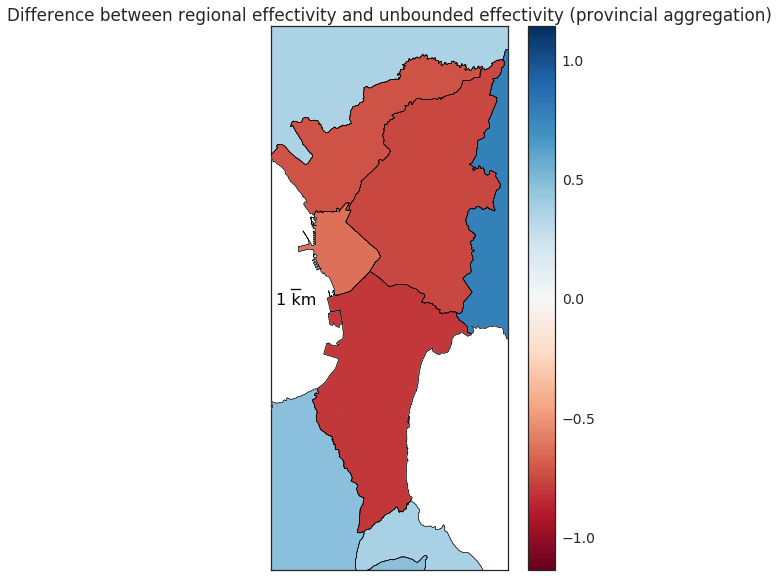

In [53]:
variable = "difference_brgy_unbound_weighted"
cmap_name = "RdBu"



vmin = barangays_PSGC_merge_nonzeroPOP[variable].min()
vmax = barangays_PSGC_merge_nonzeroPOP[variable].max()

fig, ax = plot_map(barangays_PSGC_merge, agg = provinces, country=country)

vmax = np.array(np.abs(vmin), np.abs(vmax)).max()
vmin = -vmax

fontprops = fm.FontProperties(size=16)

scale_length = 1
scalebar = AnchoredSizeBar(ax.transData,
scale_length*1e3, '%s km' % scale_length, 'center left', 
pad=0.2,
frameon=False,
size_vertical=100, #scale this
fontproperties=fontprops,
)

ax.add_artist(scalebar)


provinces.plot(ax=ax, color='none', linewidth=0.5, linestyle="--", edgecolor="black", alpha=1, legend=True, zorder=10)
provinces_merged.plot(column=variable, cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax), linewidth=0.5, ax=ax, edgecolor='None')

ax.set_xlim([NCR_minx, NCR_maxx])
ax.set_ylim([NCR_miny, NCR_maxy])


ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# ax.axis('off')
ax.set_title("Difference between regional effectivity and unbounded effectivity (provincial aggregation)")

sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax))
sm._A = []

cbar = fig.colorbar(sm)

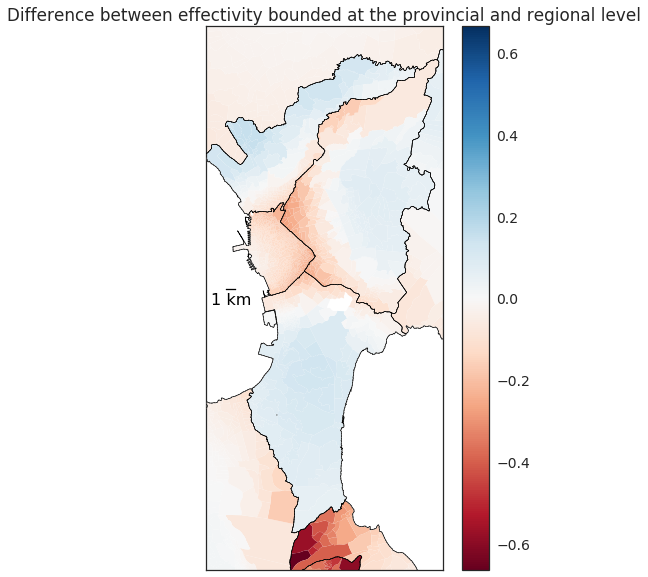

In [54]:
variable = "difference_prov_regional_weighted"
cmap_name = "RdBu"

vmin = barangays_PSGC_merge_nonzeroPOP[variable].min()
vmax = barangays_PSGC_merge_nonzeroPOP[variable].max()

fig, ax = plot_map(barangays_PSGC_merge, agg = provinces, country=country)

vmax = np.array(np.abs(vmin), np.abs(vmax)).max()
vmin = -vmax

fontprops = fm.FontProperties(size=16)

scale_length = 1
scalebar = AnchoredSizeBar(ax.transData,
scale_length*1e3, '%s km' % scale_length, 'center left', 
pad=0.2,
frameon=False,
size_vertical=100, #scale this
fontproperties=fontprops,
)

ax.add_artist(scalebar)


provinces.plot(ax=ax, color='none', linewidth=0.5, linestyle="--", edgecolor="black", alpha=1, legend=True, zorder=10)
barangays_PSGC_merge_nonzeroPOP.plot(column=variable, cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax), linewidth=0.5, ax=ax, edgecolor='None')

ax.set_xlim([NCR_minx, NCR_maxx])
ax.set_ylim([NCR_miny, NCR_maxy])


ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# ax.axis('off')
ax.set_title("Difference between effectivity bounded at the provincial and regional level")

sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax))
sm._A = []

cbar = fig.colorbar(sm)

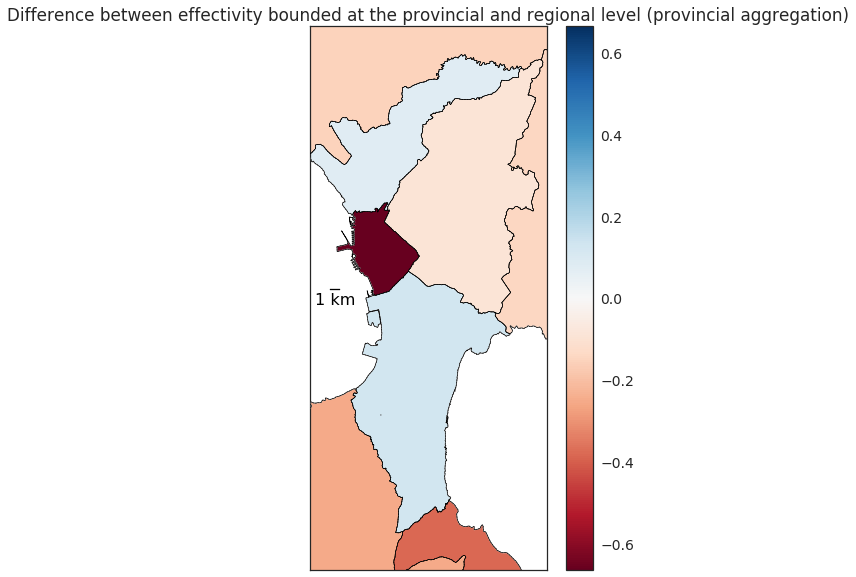

In [55]:
variable = "difference_prov_regional_weighted"
cmap_name = "RdBu"

vmin = barangays_PSGC_merge_nonzeroPOP[variable].min()
vmax = barangays_PSGC_merge_nonzeroPOP[variable].max()

fig, ax = plot_map(barangays_PSGC_merge, agg = provinces, country=country)

vmax = np.array(np.abs(vmin), np.abs(vmax)).max()
vmin = -vmax

fontprops = fm.FontProperties(size=16)

scale_length = 1
scalebar = AnchoredSizeBar(ax.transData,
scale_length*1e3, '%s km' % scale_length, 'center left', 
pad=0.2,
frameon=False,
size_vertical=100, #scale this
fontproperties=fontprops,
)

ax.add_artist(scalebar)


provinces.plot(ax=ax, color='none', linewidth=0.5, linestyle="--", edgecolor="black", alpha=1, legend=True, zorder=10)
provinces_merged.plot(column=variable, cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax), linewidth=0.5, ax=ax, edgecolor='None')

ax.set_xlim([NCR_minx, NCR_maxx])
ax.set_ylim([NCR_miny, NCR_maxy])


ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# ax.axis('off')
ax.set_title("Difference between effectivity bounded at the provincial and regional level (provincial aggregation)")

sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax))
sm._A = []

cbar = fig.colorbar(sm)

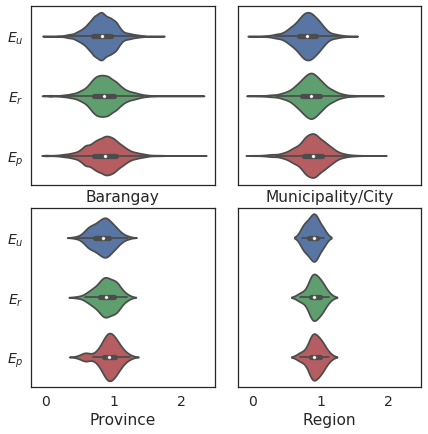

In [56]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize =(7,7))

MunicipalityGroup = barangays_PSGC_merge.groupby("PSGC_6Digit").sum()
MunicipalityGroup["effectivity_weighted"] = MunicipalityGroup.el_students_in_barangay_weighted/np.ceil(MunicipalityGroup.POP2K*pop_scaling_factor)
MunicipalityGroup["effectivity_weighted_regional"] = MunicipalityGroup.el_students_in_brgy_weighted_regional/np.ceil(MunicipalityGroup.POP2K*pop_scaling_factor)
MunicipalityGroup["effectivity_weighted_provincial"] = MunicipalityGroup.el_students_in_brgy_weighted_provincial/np.ceil(MunicipalityGroup.POP2K*pop_scaling_factor)

ProvinceGroup = barangays_PSGC_merge.groupby("Province_Brgy").sum()
ProvinceGroup["effectivity_weighted"] = ProvinceGroup.el_students_in_barangay_weighted/np.ceil(ProvinceGroup.POP2K*pop_scaling_factor)
ProvinceGroup["effectivity_weighted_regional"] = ProvinceGroup.el_students_in_brgy_weighted_regional/np.ceil(ProvinceGroup.POP2K*pop_scaling_factor)
ProvinceGroup["effectivity_weighted_provincial"] = ProvinceGroup.el_students_in_brgy_weighted_provincial/np.ceil(ProvinceGroup.POP2K*pop_scaling_factor)

RegionGroup = barangays_PSGC_merge.groupby("RegionName").sum()
RegionGroup["effectivity_weighted"] = RegionGroup.el_students_in_barangay_weighted/np.ceil(RegionGroup.POP2K*pop_scaling_factor)
RegionGroup["effectivity_weighted_regional"] = RegionGroup.el_students_in_brgy_weighted_regional/np.ceil(RegionGroup.POP2K*pop_scaling_factor)
RegionGroup["effectivity_weighted_provincial"] = RegionGroup.el_students_in_brgy_weighted_provincial/np.ceil(RegionGroup.POP2K*pop_scaling_factor)

AdminLabels = ["Barangay", "Municipality/City", "Province", "Region"]

for i, axes in enumerate(ax.flatten()):
    ax.flatten()[i].set_yticklabels(["Unbounded", "Regional bounds", "Provincial bounds"])
    ax.flatten()[i].set_xlabel(AdminLabels[i])

sns.violinplot(data = barangays_PSGC_merge.loc[:,["effectivity_weighted","effectivity_weighted_regional", "effectivity_weighted_provincial"]]\
            .rename(columns = {"effectivity_weighted":r"$E_u$", "effectivity_weighted_regional":r"$E_r$", "effectivity_weighted_provincial":r"$E_p$"})\
            ,orient = 'h', ax = ax.flatten()[0])
sns.violinplot(data = MunicipalityGroup.loc[:,["effectivity_weighted","effectivity_weighted_regional", "effectivity_weighted_provincial"]]\
            .rename(columns = {"effectivity_weighted":r"$E_u$", "effectivity_weighted_regional":r"$E_r$", "effectivity_weighted_provincial":r"$E_p$"})\
            , orient = 'h', ax = ax.flatten()[1])
sns.violinplot(data = ProvinceGroup.loc[:,["effectivity_weighted","effectivity_weighted_regional", "effectivity_weighted_provincial"]]\
            .rename(columns = {"effectivity_weighted":r"$E_u$", "effectivity_weighted_regional":r"$E_r$", "effectivity_weighted_provincial":r"$E_p$"})\
            , orient = 'h', ax = ax.flatten()[2])
sns.violinplot(data = RegionGroup.loc[:,["effectivity_weighted","effectivity_weighted_regional", "effectivity_weighted_provincial"]]\
            .rename(columns = {"effectivity_weighted":r"$E_u$", "effectivity_weighted_regional":r"$E_r$", "effectivity_weighted_provincial":r"$E_p$"})\
            , orient = 'h', ax = ax.flatten()[3])
plt.subplots_adjust(wspace=0.125, hspace=0.125)

#plt.savefig("../files/images/EIDR_Effectivity_Violinplots.pdf", bbox_inches = "tight")

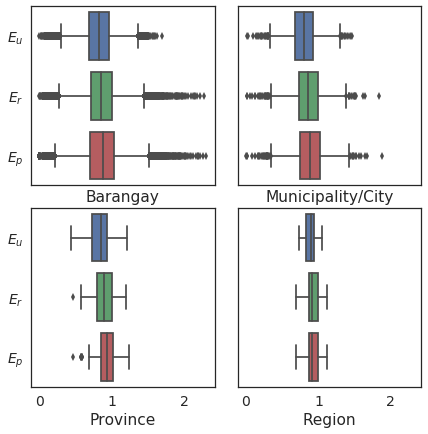

In [57]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize =(7,7))

for i, axes in enumerate(ax.flatten()):
    ax.flatten()[i].set_yticklabels(["Unbounded", "Regional bounds", "Provincial bounds"])
    ax.flatten()[i].set_xlabel(AdminLabels[i])

sns.boxplot(data = barangays_PSGC_merge.loc[:,["effectivity_weighted","effectivity_weighted_regional", "effectivity_weighted_provincial"]]\
            .rename(columns = {"effectivity_weighted":r"$E_u$", "effectivity_weighted_regional":r"$E_r$", "effectivity_weighted_provincial":r"$E_p$"})\
            ,orient = 'h', ax = ax.flatten()[0])
sns.boxplot(data = MunicipalityGroup.loc[:,["effectivity_weighted","effectivity_weighted_regional", "effectivity_weighted_provincial"]]\
            .rename(columns = {"effectivity_weighted":r"$E_u$", "effectivity_weighted_regional":r"$E_r$", "effectivity_weighted_provincial":r"$E_p$"})\
            , orient = 'h', ax = ax.flatten()[1])
sns.boxplot(data = ProvinceGroup.loc[:,["effectivity_weighted","effectivity_weighted_regional", "effectivity_weighted_provincial"]]\
            .rename(columns = {"effectivity_weighted":r"$E_u$", "effectivity_weighted_regional":r"$E_r$", "effectivity_weighted_provincial":r"$E_p$"})\
            , orient = 'h', ax = ax.flatten()[2])
sns.boxplot(data = RegionGroup.loc[:,["effectivity_weighted","effectivity_weighted_regional", "effectivity_weighted_provincial"]]\
            .rename(columns = {"effectivity_weighted":r"$E_u$", "effectivity_weighted_regional":r"$E_r$", "effectivity_weighted_provincial":r"$E_p$"})\
            , orient = 'h', ax = ax.flatten()[3])
plt.subplots_adjust(wspace=0.125, hspace=0.125)

#plt.savefig("../files/images/EIDR_Effectivity_Violinplots.png", bbox_inches = "tight")

In [58]:
barangays_PSGC_merge.loc[:,["effectivity_weighted","effectivity_weighted_regional", "effectivity_weighted_provincial"]]\
            .rename(columns = {"effectivity_weighted":r"$E_u$", "effectivity_weighted_regional":r"$E_r$", "effectivity_weighted_provincial":r"$E_p$"}).head(5)

,$E_u$,$E_r$,$E_p$
0,1.036587,0.748078,0.596526
1,0.969978,0.683458,0.590659
2,0.935106,0.634927,0.518543
3,0.927180,0.630187,0.476257
4,0.917624,0.625825,0.494118
